# Sites Price Diff - Stage D

## Installs and import

In [ ]:
%pip install thefuzz

   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 7.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

## Pre-Processing

### Load Data

In [2]:
booking_data = pd.read_csv('./data/booking/processed_booking_snapshot_2025-03-09.csv')
agoda_data = pd.read_csv('./data/agoda/processed_agoda_snapshot_2025-03-09.csv')
booking_data.columns

Index(['name', 'original_price', 'discounted_price', 'discount',
       'review_score', 'review_title', 'number_of_reviews', 'star_rating',
       'is_apartment', 'neighborhood', 'kms_from_centre', 'location_score',
       'bed_type', 'room_type', 'breakfast_included', 'free_cancellation',
       'prepayment_needed', 'time_to_travel', 'length_of_stay',
       'snapshot_date', 'discounted_price_per_night',
       'original_price_per_night', 'review_title_rank', 'bed_type_rank',
       'Chelsea', 'Chinatown', 'East Harlem', 'East Village',
       'Flatiron District', 'Gramercy', 'Greenwich Village', 'Harlem',
       'Hell's Kitchen', 'Hudson Yards', 'Kips Bay', 'Little Italy',
       'Lower East Side', 'Manhattan', 'Midtown East', 'Murray Hill',
       'New York', 'NoMad', 'SoHo', 'Tribeca', 'Union Square',
       'Upper East Side', 'Upper West Side', 'Washington Heights'],
      dtype='object')

In [3]:
booking_data['breakfast_included'] = booking_data['breakfast_included'].astype(bool).astype(int)
booking_data['free_cancellation'] = booking_data['free_cancellation'].astype(bool).astype(int)
booking_data['prepayment_needed'] = booking_data['prepayment_needed'].astype(bool).astype(int)

booking_data['price'] = booking_data['discounted_price_per_night']

booking_data.drop(columns=['discount', 'original_price', 'discounted_price',
        'review_title',
       'is_apartment', 'neighborhood', 'kms_from_centre',
       'bed_type', 'room_type', 
       'original_price_per_night', 'review_title_rank', 'bed_type_rank', 'discounted_price_per_night'
       ], inplace=True)

booking_data.fillna(booking_data['location_score'].min(), inplace=True)

agoda_data['price'] = agoda_data['discounted_price']
agoda_data.drop(columns=['discounted_price'], inplace=True)


### Merge By Name


To effectively compare hotel prices across Agoda and Booking, the data from both sources must first be merged based on a reliable, consistent key. We select the composite key `<name, snapshot_date, length_of_stay, time_to_travel>`, as this ensures that each row in the merged dataset uniquely identifies a specific hotel for a given query snapshot. Specifically, each page represents a distinct combination of snapshot date, duration of stay, and time until travel, while each hotel within a page remains uniquely identifiable by its name.

However, merging solely by exact hotel names drastically reduces data utility: starting with approximately **26K rows** from Agoda and **12K rows** from Booking, a direct merge yields merely **1K results** due to naming inconsistencies between the two sources. Initially, merging by hotel address was considered as an alternative, but this was not feasible due to unavailable address data.

To address this limitation, we implemented **fuzzy string matching** to normalize hotel names before merging. Fuzzy matching helps identify names that are highly similar but not identical by calculating a similarity metric between pairs of strings. Specifically, our approach involves checking if the hotel name from one dataset is entirely contained within the hotel name from the other. For instance, the hotel labeled as `"ac hotel new york downtown"` in Agoda appears as `"ac hotel by marriott new york downtown"` in Booking. These variations, while minor, significantly impact exact matching.

A hotel from Agoda and Booking will thus be merged if:
- The Booking.com hotel name is fully included (⊆) within the Agoda hotel name,  
**OR**
- The Agoda hotel name is fully included (⊆) within the Booking.com hotel name.

This normalization strategy considerably increases the effectiveness and accuracy of our merged dataset, providing more meaningful insights into comparative hotel pricing across platforms. 🌐🔍


#### normalize names

In [4]:
import re
import pandas as pd

def normalize_name(name):
    """
    Normalizes the name by converting to lowercase, removing ignored substrings,
    punctuation, and extra spaces.
    """
    if pd.isnull(name) or not name:
        return ""
    # Convert to lowercase.
    name = name.lower()
    # Remove punctuation; adjust regex as needed.
    name = re.sub(r'[^\w\s]', '', name)
    # Remove extra spaces.
    name = re.sub(r'\s+', ' ', name).strip()
    return name

In [5]:
agoda_data['name'] = agoda_data['name'].apply(normalize_name)
booking_data['name'] = booking_data['name'].apply(normalize_name)

#### Find names intersection
Find out how many unique hotel names are included in both of the sites (intersection),
which ones are unique to agoda and which ones are unique to bookings

In [6]:
agoda_names = agoda_data['name'].unique()
booking_names = booking_data['name'].unique()
agoda_set = set(agoda_names)
booking_set = set(booking_names)

intersection_set = agoda_set & booking_set

agoda_only_set = agoda_set - booking_set
booking_only_set = booking_set - agoda_set

intersection = list(intersection_set)
agoda_only = list(agoda_only_set)
agoda_only.sort()
booking_only = list(booking_only_set)
booking_only.sort()

print("Intersection:", len(intersection))
print("Agoda Only:", len(agoda_only))
print("Booking Only:", len(booking_only))

Intersection: 188
Agoda Only: 393
Booking Only: 175


As we can see from the result of the code above, some names of hotels are the same with slight differences. To mitigate this problem while merging the datasets, we  will use a similiaty score to group similiar names together.

For example the AC hotel is listed as `Best Western PREMIER Herald Square` on booking, but on agoda it is listed as `Best Western Premier Herald Square`

#### Find similiarities


The `token_set_ratio` is a method from fuzzy string matching that first splits each string into individual words (tokens) and converts them into a set to ignore duplicate words and their order. It then computes a similarity score based solely on the common tokens between the two strings. This is especially useful for comparing names or phrases where the order of words might differ or where one string might have extra words that don’t change its overall identity.

We used it to know if there is a full inclusion between names from two sets, without ordering, and by that we knew if two hotels are the same one.

We added canonical hotel names, which are the shorter name between the ones listed on the internet

In [7]:
import pandas as pd
from thefuzz import fuzz


threshold = 100
similar_matches = []

for agoda in agoda_only:
    norm_agoda = normalize_name(agoda)
    best_match = None
    best_score = 0
    for booking in booking_only:
        norm_booking = normalize_name(booking)
        score = fuzz.token_set_ratio(norm_agoda, norm_booking)
        if score > best_score:
            best_score = score
            best_match = booking
    # If the best match meets or exceeds the threshold, record the pair.
    if best_score >= threshold:
        canonical = agoda if len(agoda) < len(best_match) else best_match
        similar_matches.append((agoda, best_match, best_score, canonical))

# Output the matched pairs
print(f"{len(similar_matches)} Similar matches between agoda_only and booking_only (ignoring substrings):")
for agoda_name, booking_name, score, canonical in similar_matches:
    print(f"{canonical}: Agoda: '{agoda_name}' <--> Booking: '{booking_name}' (Score: {score})")


100 Similar matches between agoda_only and booking_only (ignoring substrings):
ac hotel new york downtown: Agoda: 'ac hotel new york downtown' <--> Booking: 'ac hotel by marriott new york downtown' (Score: 100)
ac hotel new york times square: Agoda: 'ac hotel new york times square' <--> Booking: 'ac hotel by marriott new york times square' (Score: 100)
ace hotel: Agoda: 'ace hotel' <--> Booking: 'ace hotel new york' (Score: 100)
park central: Agoda: 'aka central park' <--> Booking: 'park central' (Score: 100)
ameritania at times square: Agoda: 'ameritania hotel at times square' <--> Booking: 'ameritania at times square' (Score: 100)
aura hotel times square: Agoda: 'aura hotel times square' <--> Booking: 'aura hotel times square newly renovated' (Score: 100)
belvedere hotel: Agoda: 'belvedere hotel' <--> Booking: 'the belvedere hotel' (Score: 100)
candlewood suites nyc times square: Agoda: 'candlewood suites nyc times square' <--> Booking: 'candlewood suites nyc times square by ihg' (Sc

#### Transform names to canonical

use the canonical names instead of the original ones for the merging. 

In [8]:
# transform the names from all hotels inplace at the dataframes
for agoda, booking, _score, canonical in similar_matches:
    booking_data.loc[booking_data['name'] == booking, 'name'] = canonical
    agoda_data.loc[agoda_data['name'] == agoda_name, 'name'] = canonical


In [9]:
def add_check_in_col(df):
    df['snapshot_date'] = pd.to_datetime(df['snapshot_date'], format='%Y-%m-%d')  # Correct format
    df['checkin_date'] = df['snapshot_date'] + pd.to_timedelta(df['time_to_travel'], unit='D')  # Add days
    df['checkin_day'] = df['checkin_date'].dt.day  # Extract day of the month

In [10]:
add_check_in_col(booking_data)
add_check_in_col(agoda_data)

In [11]:
booking_data = booking_data.drop_duplicates(subset=['name', 'checkin_date', 'length_of_stay'])
agoda_data = agoda_data.drop_duplicates(subset=['name', 'checkin_date', 'length_of_stay'])

In [12]:
print(booking_data.columns)
print(agoda_data.columns)

Index(['name', 'review_score', 'number_of_reviews', 'star_rating',
       'location_score', 'breakfast_included', 'free_cancellation',
       'prepayment_needed', 'time_to_travel', 'length_of_stay',
       'snapshot_date', 'Chelsea', 'Chinatown', 'East Harlem', 'East Village',
       'Flatiron District', 'Gramercy', 'Greenwich Village', 'Harlem',
       'Hell's Kitchen', 'Hudson Yards', 'Kips Bay', 'Little Italy',
       'Lower East Side', 'Manhattan', 'Midtown East', 'Murray Hill',
       'New York', 'NoMad', 'SoHo', 'Tribeca', 'Union Square',
       'Upper East Side', 'Upper West Side', 'Washington Heights', 'price',
       'checkin_date', 'checkin_day'],
      dtype='object')
Index(['name', 'star_rating', 'review_score', 'number_of_reviews',
       'distance_from_center', 'free_cancellation', 'prepayment_needed',
       'breakfast_included', 'time_to_travel', 'length_of_stay',
       'snapshot_date', 'price', 'checkin_date', 'checkin_day'],
      dtype='object')


#### Merge the DataFrames

In [13]:
merged_data = pd.merge(booking_data, agoda_data, on=['name', 'checkin_date','length_of_stay', 'snapshot_date', 'time_to_travel'], suffixes=('_booking', '_agoda'), how='inner')

#### Add name as column

In [14]:
le = LabelEncoder()
merged_data['name_encoded'] = le.fit_transform(merged_data['name'])

In [15]:
print(booking_data.__len__())
print(agoda_data.__len__())
print(merged_data.__len__())
display(merged_data)


14235
26853
4932


,name,review_score_booking,number_of_reviews_booking,star_rating_booking,location_score,breakfast_included_booking,free_cancellation_booking,prepayment_needed_booking,time_to_travel,length_of_stay,...,star_rating_agoda,review_score_agoda,number_of_reviews_agoda,distance_from_center,free_cancellation_agoda,prepayment_needed_agoda,breakfast_included_agoda,price_agoda,checkin_day_agoda,name_encoded
0,fairfield inn by marriott new york manhattanfi...,7.8,3648.0,3.0,9.3,1,0,1,1,1,...,3.0,8.0,3895.0,4.2,0,0,1,140.0,10,39
1,u hotel fifth avenue,7.9,3396.0,3.0,9.5,0,0,1,1,1,...,3.0,8.2,4227.0,0.0,0,0,0,150.0,10,148
2,four points by sheraton new york downtown,7.9,2036.0,3.0,9.3,0,1,0,1,1,...,5.0,8.1,2374.0,4.2,1,0,1,197.0,10,43
3,millennium hotel broadway times square,7.4,7873.0,4.0,9.4,0,0,1,1,1,...,4.0,7.7,429.0,0.0,0,0,0,243.0,10,88
4,the new yorker a wyndham hotel,7.7,15579.0,4.0,9.4,0,0,1,1,1,...,4.0,7.8,14729.0,0.0,0,1,0,187.0,10,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4927,westgate new york grand central,8.4,33.0,4.0,9.3,0,0,1,30,5,...,4.0,8.1,190.0,0.0,0,1,0,300.0,8,153
4928,concorde hotel new york,8.7,1715.0,4.0,9.5,0,0,1,30,5,...,4.0,8.9,2192.0,0.0,0,1,0,371.0,8,26
4929,hotel edison,7.7,13151.0,4.0,9.4,1,1,0,30,5,...,4.0,7.8,12865.0,0.0,0,1,1,434.0,8,62
4930,ace hotel,7.6,1786.0,4.0,9.3,0,0,1,30,5,...,4.0,8.4,629.0,0.0,0,1,1,407.0,8,4


After merging the datasets, we observe that the resulting data utilization is suboptimal, retaining only approximately **5,000** rows from an initial combined total of roughly **40,000** rows from Agoda and Booking. This low retention rate highlights significant potential for improvement in our merging strategy. To further optimize data utilization, several approaches can be explored:

- **Name Similarity using NLP Models:** Implement Natural Language Processing (NLP) models, such as fuzzy matching algorithms, embeddings-based similarity (e.g., Sentence-BERT), or other deep-learning-based text similarity techniques, to accurately detect similar hotel names beyond simple substring matching.

- **Leveraging External LLM APIs:** Utilize external Large Language Model (LLM) APIs (such as OpenAI's GPT) to semantically identify similar hotel names. Such models can capture nuanced name similarities that traditional methods might overlook.

- **Extracting and Including Addresses:** Obtain and integrate hotel addresses into the merging process, using them as part of the primary key instead of relying solely on hotel names. Addresses tend to be more consistent across platforms and may substantially improve matching accuracy.



### 💰 Adding the Price Difference Column

To effectively test our models, we introduce a new column, **`price_difference`**, defined as the difference between Agoda's price and Booking's price:

\[
price_difference = price_agoda - price_booking
\]

- **Positive values (+)** indicate that the hotel is more expensive on Agoda compared to Booking. 📈
- **Negative values (-)** suggest that Booking's listed price is higher for the same hotel. 📉

This calculated difference will enable us to evaluate model performance and analyze pricing trends accurately across both platforms.

In [16]:
merged_data['price_difference'] = merged_data['price_agoda'] - merged_data['price_booking']

In [17]:
merged_data['price_difference'].describe()

count    4932.000000
mean       -0.775226
std        25.225683
min      -230.000000
25%        -1.666667
50%         0.000000
75%         0.400000
max       879.500000
Name: price_difference, dtype: float64

From the above table we can conclude that on average booking tends to be a slightly more expensive platform. There are also extreme outliers in the price difference - whie most of the price differences tend to fall between one to 2 dolars per night, there are some cases where the price difference can rise for up to 880 dolars per night!
 

### 🧹 Removing Extreme Outliers from Price Differences

The box plot below indicates that the price differences between Agoda and Booking typically cluster around **0**, meaning hotel prices on both platforms are generally similar. With the first quartile (Q1) at **-1.6** and the third quartile (Q3) at **0.4**, we observe that, in most cases, prices on Booking tend to be slightly higher. Although the absolute price difference ranges broadly from **0 to approximately $800**, most values typically fall within a much narrower range of **$0–$3.5 per night**. Therefore, these extreme outliers—significantly deviating from typical price differences—may negatively impact the accuracy and generalization of the models. Consequently, removing these outliers is crucial to ensure stable and reliable model performance. ⚠️📉

In [18]:
# plot the price difference using plotly boxplot
import plotly.express as px
fig = px.box(merged_data['price_difference'], y="price_difference")
fig.show()


In [19]:
Q1 = merged_data['price_difference'].quantile(0.25)
Q3 = merged_data['price_difference'].quantile(0.75)
IQR = Q3 - Q1

merged_data = merged_data[(merged_data['price_difference'] >= (Q1 - 1.5 * IQR)) & (merged_data['price_difference'] <= (Q3 + 1.5 * IQR))]
merged_data['price_difference'].describe()


count    3007.000000
mean       -0.244712
std         1.010671
min        -4.750000
25%        -0.333333
50%         0.000000
75%         0.200000
max         3.333333
Name: price_difference, dtype: float64

In [20]:
# plot the price difference using plotly boxplot
import plotly.express as px
fig = px.box(merged_data['price_difference'], y="price_difference")
fig.show()


In [21]:
import plotly.express as px

fig = px.histogram(
    merged_data, 
    x='price_difference', 
    nbins=100,
    marginal='box',  # adds a box plot on the top
    title='Distribution of Price Differences (Agoda - Booking)',
    labels={'price_difference':'Price Difference ($)'}
)

fig.update_layout(bargap=0.1)
fig.show()

From the distribution plot above, after removing extreme outliers, the price difference primarily ranges between -5 and 3 dollars. However, most values cluster closely around 0 to 1 dollar, indicating that, after cleanup, price variations between Agoda and Booking generally remain minimal. 📊✨

In [22]:
# merged_data['checkin_date'] = pd.to_datetime(merged_data['checkin_date'])
# merged_data['checkin_date'] = (merged_data['checkin_date'] - merged_data['checkin_date'].min()).dt.days
non_numeric_cols = merged_data.select_dtypes( exclude=['number']).columns
non_numeric_cols

predefined_droped_cols = [*non_numeric_cols, 'price_agoda', 'price_booking', 'price_difference', 'checkin_day_booking', 'checkin_day_agoda']

# drop all columns where the min and max are the same that are not the snapshot_date
merged_data = merged_data.drop(columns=merged_data.columns[(merged_data.min() == merged_data.max()) & (merged_data.columns != 'snapshot_date')])

### Create data set for training

In [23]:
X = merged_data.drop(columns=predefined_droped_cols)# Replace with actual features
y = merged_data['price_difference']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Training

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

def tune_model(model, param_grid, X_train, y_train, cv=5):
    scoring = {
        'R2': 'r2',
        'neg_mean_squared_error': 'neg_mean_squared_error',
        'neg_mean_absolute_error': 'neg_mean_absolute_error'
    }
    
    grid = GridSearchCV(estimator=model,
                        param_grid=param_grid,
                        cv=cv,
                        scoring=scoring,
                        refit='R2',  # refitting on R² ensures the best model maximizes explained variance
                        n_jobs=-1,
                        verbose=1)
    grid.fit(X_train, y_train)

    
    print(f"Best grid R2 score for {model.__class__.__name__}: {grid.best_score_}")
    print(f"Best grid parameters for {model.__class__.__name__}: {grid.best_params_}")
  
    # Optionally, you can access all the cross-validation results via grid.cv_results_
    return grid.best_estimator_

In [27]:
param_grids = {
    'Decision Tree': {
        'max_depth': [None, 5],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [1, 2]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
}

models = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42)
}

best_models = {}
for model_name, model in models.items():
    print(f"\nTuning {model_name}:")
    best_models[model_name] = tune_model(model, param_grids[model_name], X_train_scaled, y_train)



Tuning Decision Tree:
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best grid R2 score for DecisionTreeRegressor: 0.35518850184229767
Best grid parameters for DecisionTreeRegressor: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}

Tuning Random Forest:
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best grid R2 score for RandomForestRegressor: 0.49567437632018263
Best grid parameters for RandomForestRegressor: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [28]:
results = {}

for name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)
    print(f'fit and pred: {name}')
    # Calculate performance metrics
    results[name] = {
        'R2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    }
    print(f'logged: {name}')


fit and pred: Decision Tree
logged: Decision Tree
fit and pred: Random Forest
logged: Random Forest


## Testing results

In [29]:
results_df = pd.DataFrame(results).T
print(results_df)

                     R2       MAE       MSE      RMSE
Decision Tree  0.405555  0.402767  0.542474  0.736528
Random Forest  0.502569  0.373811  0.453942  0.673752


The testing results indicate that the Random Forest model consistently outperforms the Decision Tree across all evaluation metrics. Specifically, the Random Forest provides a stronger predictive capability, resulting in lower errors when estimating hotel price differences between Agoda and Booking. On average, predictions made by the Random Forest deviate less from the actual prices, offering more accurate and reliable results measured in dollars. Conversely, the Decision Tree model exhibits higher prediction errors, implying it's less effective at capturing the underlying patterns in the pricing data.

### Residuals plot - random forest:

The residuals plot is defined as the difference between the actual price difference - predicted price difference. When the Mean of the residuals plot sits closer to 0, it means that the model predicts more accurately.
from the below plot, we can see that the model tends to predict price differences that are close to the original, with about 2 dollar variation from the actual price differnce

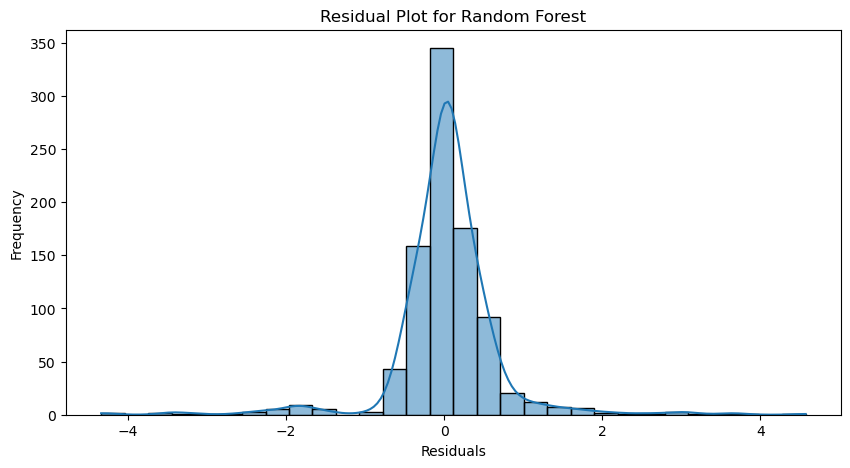

In [33]:
best_model_name = results_df['R2'].idxmax()
best_model = best_models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)
residuals = y_test - y_pred_best

plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.title(f'Residual Plot for {best_model_name}')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


### Feature importance - Tree wise

The feature importance graph below suggests that for both of the models, the most important features are the `TTT`, `number_of_reviews_agoda` and `review_score_booking`. This gives us insight on how each of the platforms are pricing hotels listed on their sites.

C:\Users\HamamaHome\AppData\Local\Temp\ipykernel_7528\572544589.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




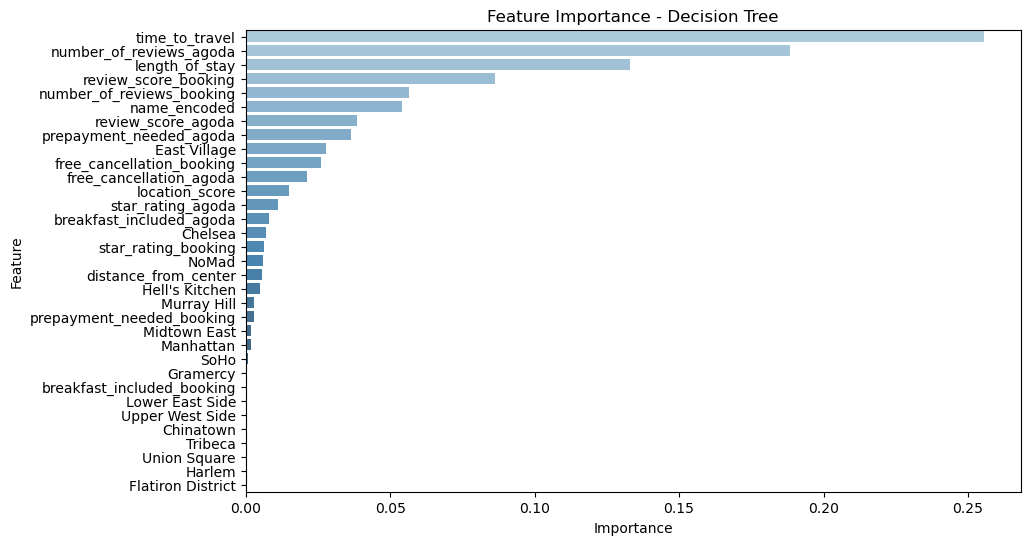

C:\Users\HamamaHome\AppData\Local\Temp\ipykernel_7528\572544589.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




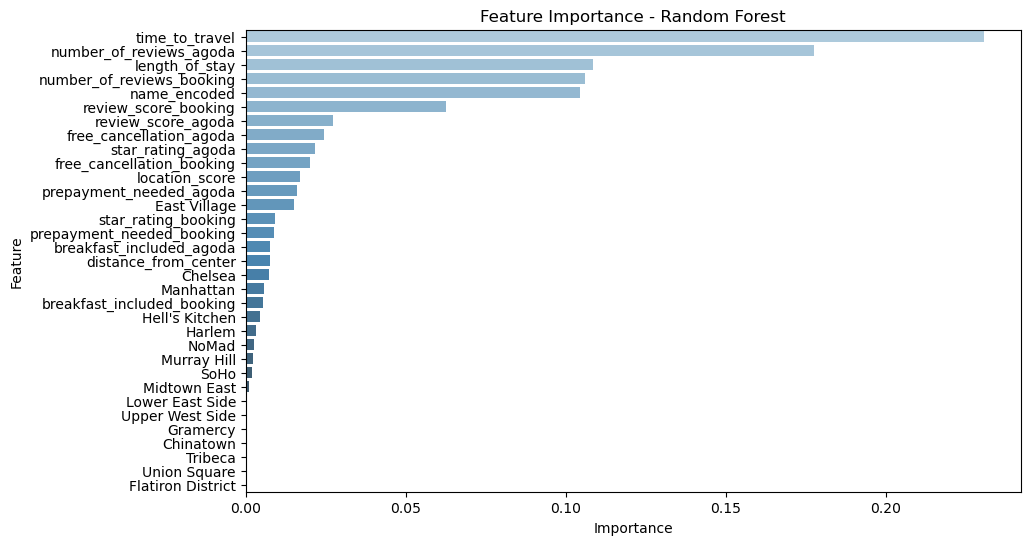

In [ ]:
for model_name in ['Decision Tree', 'Random Forest']:
    model = models[model_name]
    feature_importance = model.feature_importances_
    
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
    plt.title(f'Feature Importance - {model_name}')
    plt.show()

### permutaion importance
With this technique, we shuffle the data for each column to see how important the feature for the prediction of the model. We can conclude a similiar thing here as well - the number of reviews, the time to travel and the the review scores are the leading factors for the price difference on both sites.

C:\Users\HamamaHome\AppData\Local\Temp\ipykernel_7528\385583814.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




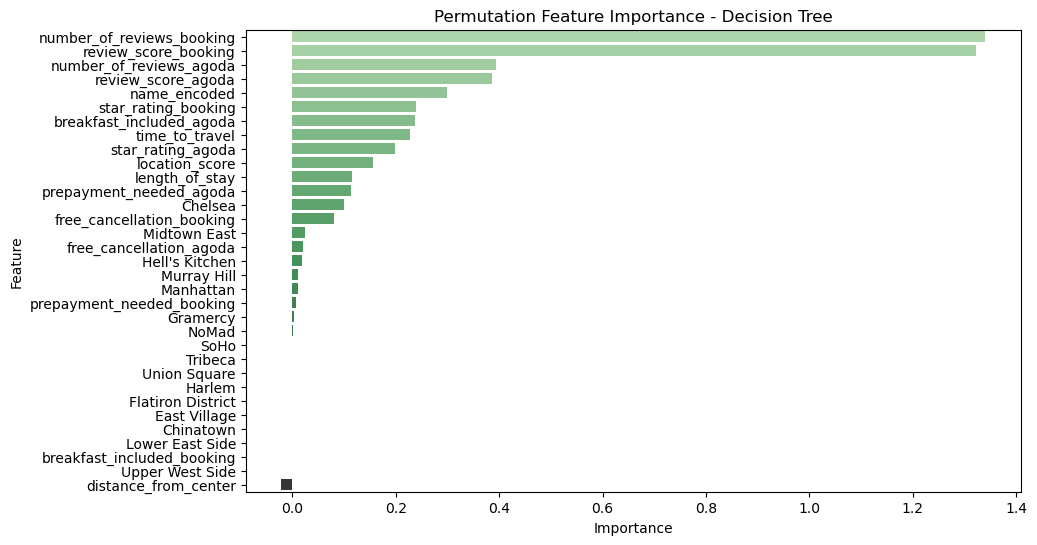

C:\Users\HamamaHome\AppData\Local\Temp\ipykernel_7528\385583814.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




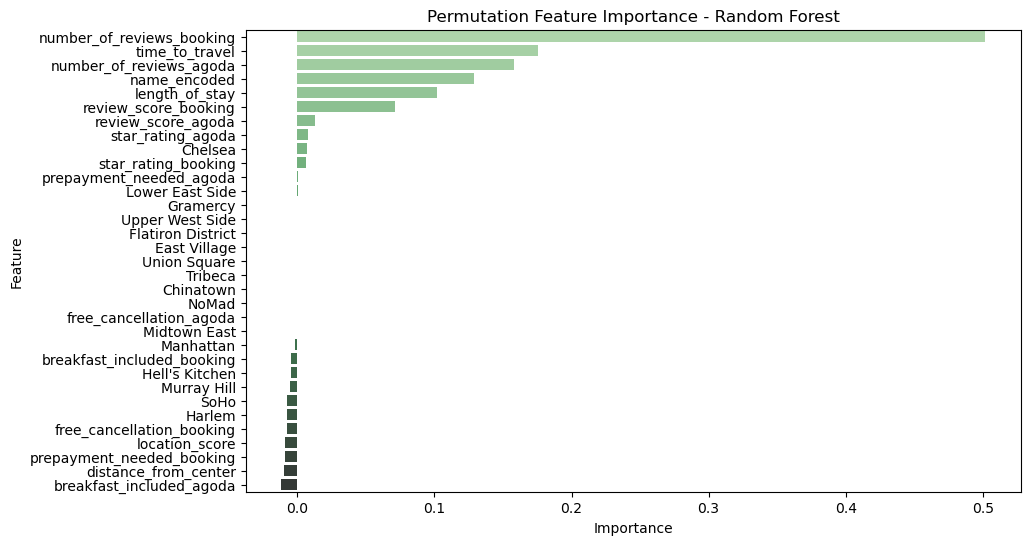

In [ ]:
for model_name in ['Decision Tree', 'Random Forest']:
    model = models[model_name]
    perm_importance = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42)
    
    perm_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': perm_importance.importances_mean
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=perm_importance_df, palette="Greens_d")
    plt.title(f'Permutation Feature Importance - {model_name}')
    plt.show()
